# Data Description and Project Goals

## Abstract

This project uses a Covid-19 dataset that contains over 1 million unique patients and 21 columns. Some of the main features of this
dataset set consist of patient type, age, pneumonia, COPD, diabetes, and more. First, we verified whether the data was clean and
generated charts to view the distribution of each of the features in the dataset to look for imbalances. We did have to generate a
new column to provide a binary classification for whether a patient had died from Covid-19. The main goal of this project was to train a supervised machine learning model and determine whether a patient is at risk given their current symptom, status, and medical history.

# Data Preparation and Feature Engineering

## Creating Spark Session

In [12]:
# Create PySpark session

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Covid19").getOrCreate()

## Loading the Dataset

In [14]:
# Load the CSV dataset
df = spark.read.csv("covid_data.csv", header=True, inferSchema=True)

# Show the first 5 rows
df.show(5)

# Print the schema
df.printSchema()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

In [15]:
# Create temp view
df.createOrReplaceTempView("covid")

## Feature Engineering

In [16]:
# Create a column 'hasDied' that is set to 1 if the patient has died, 0 otherwise
from pyspark.sql.functions import when

default_date = "9999-99-99"

df = df.withColumn("hasDied", when(df["DATE_DIED"] == default_date, 0).otherwise(1))

df.show(5)

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|hasDied|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-------+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|      1|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|         

In [17]:
# Drop the 'DATE_DIED' column
df = df.drop("DATE_DIED")

## Data Exploration

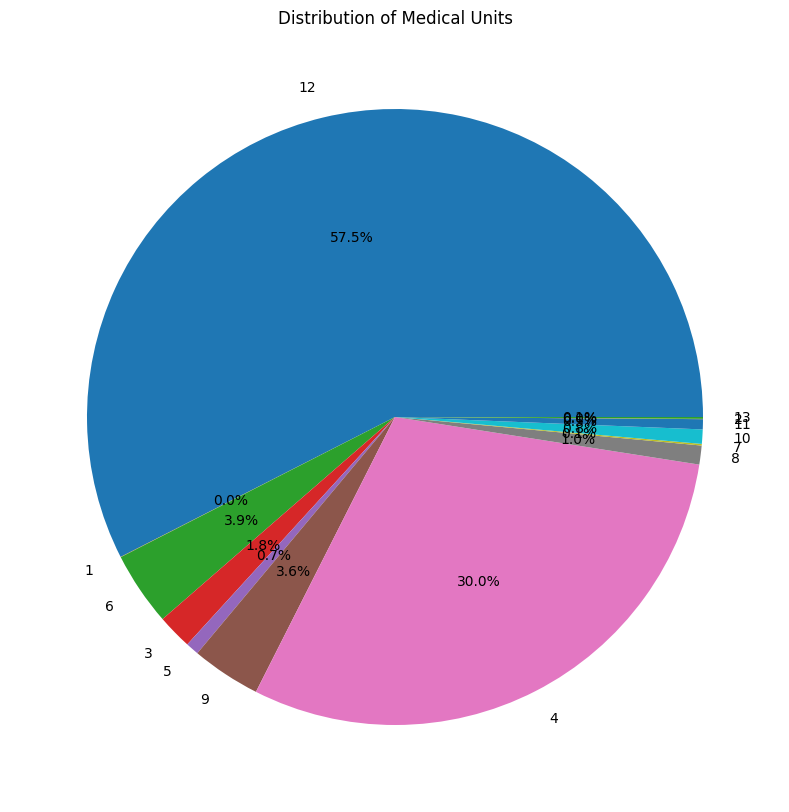

In [18]:
# Show distribute of MEDICAL_UNIT column in pie chart
import matplotlib.pyplot as plt

medical_units_distribution = spark.sql("SELECT MEDICAL_UNIT, COUNT(*) AS count FROM covid GROUP BY MEDICAL_UNIT").toPandas()

plt.figure(figsize=(15, 10))
plt.pie(medical_units_distribution["count"], labels=medical_units_distribution["MEDICAL_UNIT"], autopct="%1.1f%%")

plt.title("Distribution of Medical Units")
plt.show()

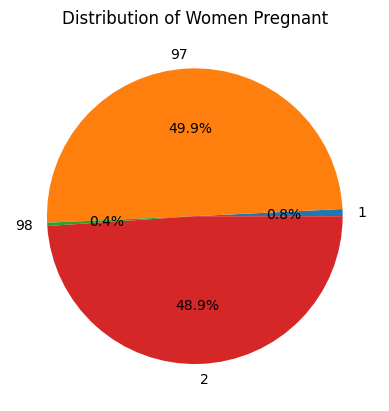

In [19]:
# Show distribution of 'PREGNANT' column in pie chart
import matplotlib.pyplot as plt

pregnant_distribution = spark.sql("SELECT PREGNANT, COUNT(*) as Count FROM covid GROUP BY PREGNANT").toPandas()

plt.pie(pregnant_distribution["Count"], labels=pregnant_distribution["PREGNANT"], autopct="%1.1f%%")
plt.title("Distribution of Women Pregnant")
plt.show()

In [20]:
# Show distribution of 'hasDied' column in pie chart
import matplotlib.pyplot as plt

died_distribution = spark.sql("SELECT hasDied, COUNT(*) as Count FROM covid GROUP BY hasDied").toPandas()

plt.pie(died_distribution["Count"], labels=died_distribution["hasDied"], autopct="%1.1f%%")
plt.title("Distribution of Patients who have died")
plt.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `hasDied` cannot be resolved. Did you mean one of the following? [`AGE`, `COPD`, `ICU`, `SEX`, `USMER`].; line 1 pos 7;
'Aggregate ['hasDied], ['hasDied, count(1) AS Count#672L]
+- SubqueryAlias covid
   +- View (`covid`, [USMER#355,MEDICAL_UNIT#356,SEX#357,PATIENT_TYPE#358,DATE_DIED#359,INTUBED#360,PNEUMONIA#361,AGE#362,PREGNANT#363,DIABETES#364,COPD#365,ASTHMA#366,INMSUPR#367,HIPERTENSION#368,OTHER_DISEASE#369,CARDIOVASCULAR#370,OBESITY#371,RENAL_CHRONIC#372,TOBACCO#373,CLASIFFICATION_FINAL#374,ICU#375])
      +- Relation [USMER#355,MEDICAL_UNIT#356,SEX#357,PATIENT_TYPE#358,DATE_DIED#359,INTUBED#360,PNEUMONIA#361,AGE#362,PREGNANT#363,DIABETES#364,COPD#365,ASTHMA#366,INMSUPR#367,HIPERTENSION#368,OTHER_DISEASE#369,CARDIOVASCULAR#370,OBESITY#371,RENAL_CHRONIC#372,TOBACCO#373,CLASIFFICATION_FINAL#374,ICU#375] csv


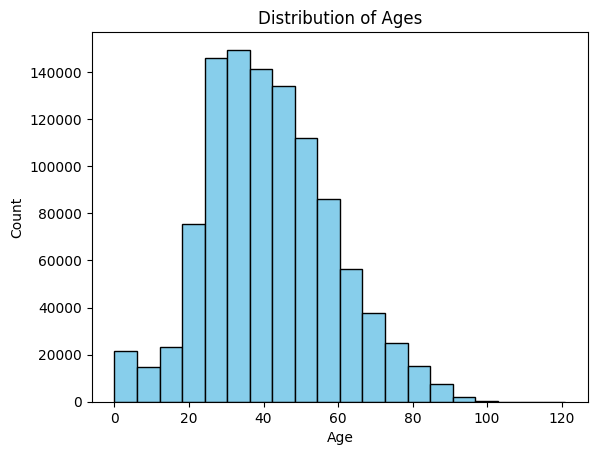

In [21]:
# Show distribution of 'AGE' column in histogram
import matplotlib.pyplot as plt

age_distribution = spark.sql("SELECT AGE FROM covid").toPandas()

plt.hist(age_distribution["AGE"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

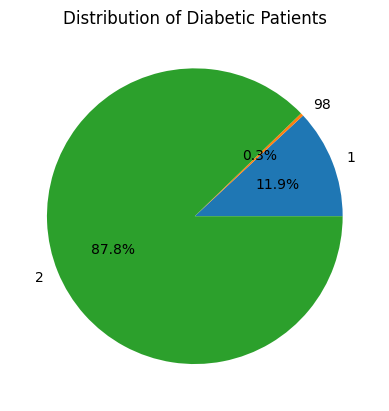

In [22]:
# Show distribution of 'DIABETES' column in pie chart
import matplotlib.pyplot as plt

diabetes_distribution = spark.sql("SELECT DIABETES, COUNT(*) as Count FROM covid GROUP BY DIABETES").toPandas()

plt.pie(diabetes_distribution["Count"], labels=diabetes_distribution["DIABETES"], autopct="%1.1f%%")
plt.title("Distribution of Diabetic Patients")
plt.show()

In [23]:
# count, mean, standard deviation, min, and max .
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+-----------------+-------------------+
|summary|             USMER|      MEDICAL_UNIT|                SEX|      PATIENT_TYPE|          INTUBED|         PNEUMONIA|               AGE|         PREGNANT|          DIABETES|              COPD|            ASTHMA|           INMSUPR|      HIPERTENSION|    OTHER_DISEASE|    CARDIOVASCULAR|          OBESITY|     RENAL_CHRONIC|           TOBACCO|CLASIFFICATION_FINAL|              ICU|            hasDied|
+-------+------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----

In [24]:
#number of rows
df.count()

1048575

In [25]:
 #number of nulls in the column
from pyspark.sql.functions import col, when, count
null_counts = []
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    null_counts.append((column, null_count))

print('Column/Null Count')
for column, count in null_counts:
    print(f"{column}:{count}")

Column/Null Count
USMER:0
MEDICAL_UNIT:0
SEX:0
PATIENT_TYPE:0
INTUBED:0
PNEUMONIA:0
AGE:0
PREGNANT:0
DIABETES:0
COPD:0
ASTHMA:0
INMSUPR:0
HIPERTENSION:0
OTHER_DISEASE:0
CARDIOVASCULAR:0
OBESITY:0
RENAL_CHRONIC:0
TOBACCO:0
CLASIFFICATION_FINAL:0
ICU:0
hasDied:0


In [26]:
# range and distribution in each feature to discover imbalances
for col in df.columns:
    df.groupBy(col).count().show()

+-----+------+
|USMER| count|
+-----+------+
|    1|385672|
|    2|662903|
+-----+------+

+------------+------+
|MEDICAL_UNIT| count|
+------------+------+
|          12|602995|
|           1|   151|
|           6| 40584|
|           3| 19175|
|           5|  7244|
|           9| 38116|
|           4|314405|
|           8| 10399|
|           7|   891|
|          10|  7873|
|          11|  5577|
|           2|   169|
|          13|   996|
+------------+------+

+---+------+
|SEX| count|
+---+------+
|  1|525064|
|  2|523511|
+---+------+

+------------+------+
|PATIENT_TYPE| count|
+------------+------+
|           1|848544|
|           2|200031|
+------------+------+

+-------+------+
|INTUBED| count|
+-------+------+
|      1| 33656|
|     97|848544|
|      2|159050|
|     99|  7325|
+-------+------+

+---------+------+
|PNEUMONIA| count|
+---------+------+
|        1|140038|
|        2|892534|
|       99| 16003|
+---------+------+

+---+-----+
|AGE|count|
+---+-----+
| 31|25927|
| 8

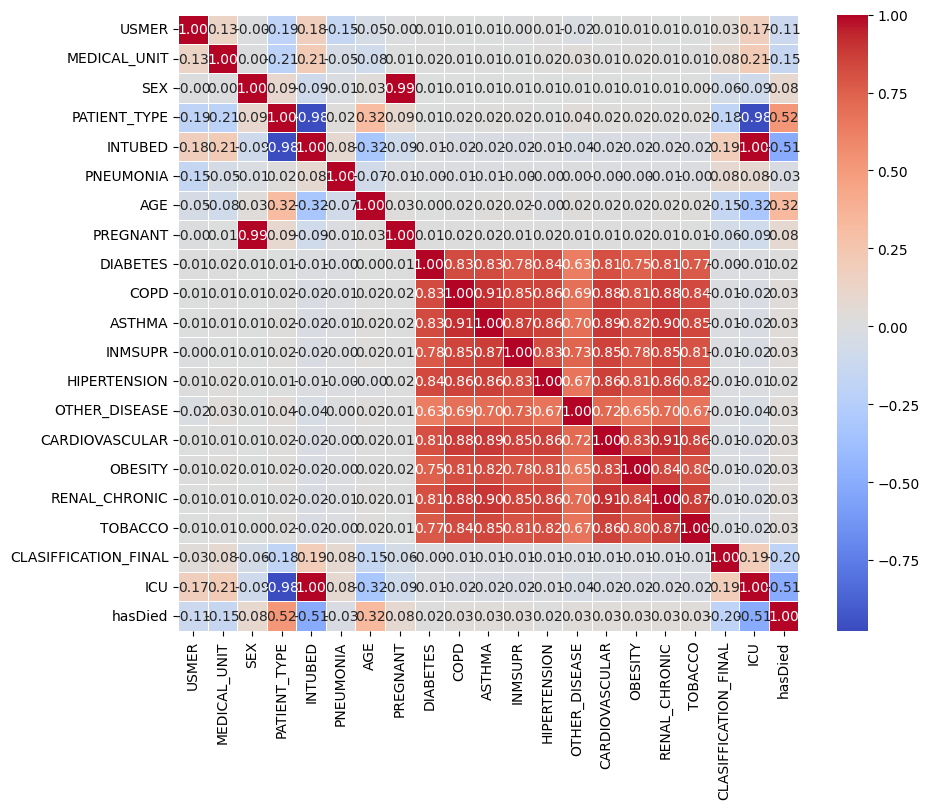

In [27]:
# correlation matrix helps us see which features are affected by each other and which have an influence on the hasDied
import seaborn as sns
import matplotlib.pyplot as plt
df_pandas = df.toPandas()
df_numerical = df_pandas.select_dtypes(include=['number'])
corrmatrix = df_numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrmatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#### Notes about Correlation Matrix:
The higer the patient's type then the more likely of the patient is or was in ICU. There is a perfect positive correlation where patients that are Intubed are in ICU. Intubed has the highest positive correlation with hasDied. There is a large box in the middle of the correlation matrix where several of the patients diseases are positively correlated with each other. From this information, we can assume that if a pateint has any of these diseases the are likely to have the others.

#### Conclusion from Data Exploration:
The target column 'hasDied' has a very imbalanced distribution. This discovery means we must consider models that can handle imbalances. Those options could be tree-based models, while Logistic Regression and Support Vector Machines can be used with editing the class weights or resampling.

# Machine Learning Algorithm Preparation and Tuning

# Model Evaluation and Visualization

# Limitations, Future Work, and Conclusion